<a href="https://colab.research.google.com/github/Louiii/VAE/blob/master/Simple_VAE_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Vartiational Autoencoder Tutorial

First, import all the necessary libraries:

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next I've included three simple functions to make and visualise some data in 2D. I decided to plot points close (with some normally distributed noise) to a piecewise function.

In [0]:
def f(x):
    n = np.random.normal(0, 0.05)
    if x < 1.3:
        return n + (x-0.5)**2
    return n - 1

def generate_data(n):
    X = np.random.uniform(0, 2, n)
    y = np.array([f(x) for x in X])
    X = np.stack([X, y])
    return torch.from_numpy(X.T).to(device).float()

def visualise(X, cmpr=None):
    plt.scatter(X[:, 0], X[:, 1], s=0.2)
    if cmpr is not None: 
        cmpr = cmpr.detach().numpy()
        plt.scatter(cmpr[:, 0], cmpr[:, 1], s=0.5, c='r', marker='X')
    plt.show()

Visualising the function:

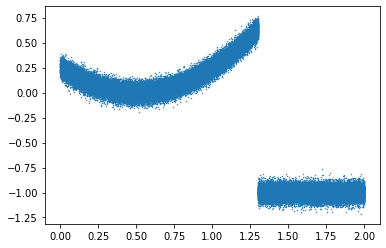

In [3]:
n = 100000
X_train, X_test = generate_data(int(0.8*n)), generate_data(int(0.2*n))
visualise(X_train)

So we want to compress this two dimensional data down into one dimension. A VAE is perfect for this, the encoder can take in a 2D coordinate and compress it to a latent representation vector with dimension 1 (a scalar), and of course the decoder will have the opposite topology.

## VAE
I now define a class in pytorch implementing a simple VAE with an input layer with two units to a hidden layer with 4 units to the latent space of 1 unit for the mean and one unit for the variation. Similarly the reverse for the decoder.


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        indim, latent = 2, 1
        self.fc1 = nn.Linear(indim, 4)
        self.fc21 = nn.Linear(4, latent)
        self.fc22 = nn.Linear(4, latent)
        self.fc3 = nn.Linear(latent, 4)
        self.fc4 = nn.Linear(4, indim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Lets use the mean squared error as this is a regression task.

In [0]:
loss_function = F.mse_loss

This loop contains the important steps for learning: predict, error, update parameters with the loss x gradient.

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimiser.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data)#, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimiser.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

An Adam (ADAptive Moment estimation) optimiser is powerful alternative to stochastic gradient descent, it uses estimations of first and second moments of the gradient to adapt the learning rate for each weight in the neural network.

In [7]:
model = VAE().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
train_loader = torch.utils.data.DataLoader(X_train,batch_size=128, shuffle=False)

epochs = 20 
for epoch in range(1, epochs + 1):
    train(epoch)
#   test(epoch)

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.011323
Train Epoch: 1 [640/80000 (1%)]	Loss: 0.009340
Train Epoch: 1 [1280/80000 (2%)]	Loss: 0.010141
Train Epoch: 1 [1920/80000 (2%)]	Loss: 0.009626
Train Epoch: 1 [2560/80000 (3%)]	Loss: 0.009002
Train Epoch: 1 [3200/80000 (4%)]	Loss: 0.010356
Train Epoch: 1 [3840/80000 (5%)]	Loss: 0.008285
Train Epoch: 1 [4480/80000 (6%)]	Loss: 0.007544
Train Epoch: 1 [5120/80000 (6%)]	Loss: 0.007580
Train Epoch: 1 [5760/80000 (7%)]	Loss: 0.006805
Train Epoch: 1 [6400/80000 (8%)]	Loss: 0.007977
Train Epoch: 1 [7040/80000 (9%)]	Loss: 0.007240
Train Epoch: 1 [7680/80000 (10%)]	Loss: 0.006875
Train Epoch: 1 [8320/80000 (10%)]	Loss: 0.006260
Train Epoch: 1 [8960/80000 (11%)]	Loss: 0.005735
Train Epoch: 1 [9600/80000 (12%)]	Loss: 0.005717
Train Epoch: 1 [10240/80000 (13%)]	Loss: 0.005770
Train Epoch: 1 [10880/80000 (14%)]	Loss: 0.005258
Train Epoch: 1 [11520/80000 (14%)]	Loss: 0.004767
Train Epoch: 1 [12160/80000 (15%)]	Loss: 0.004601
Train Epoch: 1 [12800/80000 (16%

Generate new data and predict:

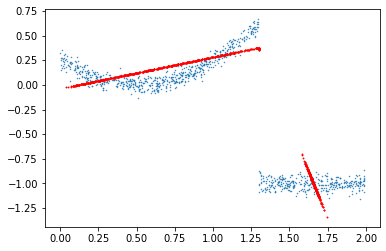

In [8]:
new_X = generate_data(1000)
recon_X, mu, logvar = model(new_X)

visualise(new_X, recon_X)

Okay, that worked, sort of... let's see if we can get any better performance with a deeper VAE.

In [0]:
class DeepVAE(nn.Module):
    def __init__(self):
        super(DeepVAE, self).__init__()
        indim, latent = 2, 1
        self.fc1 = nn.Linear(indim, 10)
        self.fc2 = nn.Linear(10, 6)
        self.fc21 = nn.Linear(6, latent)
        self.fc22 = nn.Linear(6, latent)
        self.fc3 = nn.Linear(latent, 6)
        self.fc4 = nn.Linear(6, 10)
        self.fc5 = nn.Linear(10, indim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = DeepVAE().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
model = VAE().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
train_loader = torch.utils.data.DataLoader(X_train,batch_size=128, shuffle=False)

epochs = 20 
for epoch in range(1, epochs + 1):
    train(epoch)
#   test(epoch)

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.015136
Train Epoch: 1 [640/80000 (1%)]	Loss: 0.013913
Train Epoch: 1 [1280/80000 (2%)]	Loss: 0.012823
Train Epoch: 1 [1920/80000 (2%)]	Loss: 0.012234
Train Epoch: 1 [2560/80000 (3%)]	Loss: 0.012034
Train Epoch: 1 [3200/80000 (4%)]	Loss: 0.012773
Train Epoch: 1 [3840/80000 (5%)]	Loss: 0.011014
Train Epoch: 1 [4480/80000 (6%)]	Loss: 0.010456
Train Epoch: 1 [5120/80000 (6%)]	Loss: 0.009864
Train Epoch: 1 [5760/80000 (7%)]	Loss: 0.010501
Train Epoch: 1 [6400/80000 (8%)]	Loss: 0.011325
Train Epoch: 1 [7040/80000 (9%)]	Loss: 0.010799
Train Epoch: 1 [7680/80000 (10%)]	Loss: 0.010440
Train Epoch: 1 [8320/80000 (10%)]	Loss: 0.009867
Train Epoch: 1 [8960/80000 (11%)]	Loss: 0.009647
Train Epoch: 1 [9600/80000 (12%)]	Loss: 0.009089
Train Epoch: 1 [10240/80000 (13%)]	Loss: 0.009217
Train Epoch: 1 [10880/80000 (14%)]	Loss: 0.008662
Train Epoch: 1 [11520/80000 (14%)]	Loss: 0.008346
Train Epoch: 1 [12160/80000 (15%)]	Loss: 0.007722
Train Epoch: 1 [12800/80000 (16%

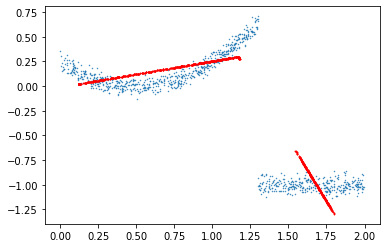

In [12]:
new_X = generate_data(1000)
recon_X, mu, logvar = model(new_X)

visualise(new_X, recon_X)

Woo! So we have shown it is possible for a VAE with a latent space with just one hidden unit to effectively represent curve data in 2D!

Let's try it on a much more complicated curve in 2D! The Louis curve!

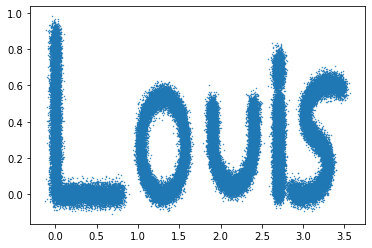

In [20]:
def louis(r):
    dx = np.random.normal(0, 0.03, 2)
    if r < 1:# L
        if r < 0.6:
            return np.array([0, np.random.uniform(0, 0.9)])+dx
        return np.array([np.random.uniform(0, 0.8), 0])+dx
    if r < 2:# o
        theta = 2*np.pi*(r-1)
        return np.array([1.3+0.27*np.cos(theta), 0.27*(1+np.sin(theta))])+dx
    if r < 3:# u
        if r < 2.4:
            if r < 2.2:
                r -= 2
                return np.array([1.9, 0.3 + r])+dx
            r -= 2.2
            return np.array([2.4, 0.3 + r])+dx
        theta = np.pi*((r-2.4)/0.6 - 1)# 180 degs
        return np.array([2.15+0.25*np.cos(theta), 0.3+0.25*np.sin(theta)])+dx
    if r < 4:# i
        if r < 3.8:
            return np.array([2.7, 0.65*(r-3)])+dx
        return np.array([2.7, 0.65*(r-3)+0.1])+dx
    # s
    theta = 2*np.pi*(r-4)
    x, y = 0.3*np.cos(theta)+3, 0.3*np.sin(theta)+0.3
    if theta < np.pi*1.32 and theta > np.pi*0.32:# top half of the s
        return np.array([x+0.6*np.cos(np.pi*0.32), 0.55*(y+0.6*np.sin(np.pi*0.32))])+dx
    return np.array([x, 0.55*y])+dx

def gen_louis(n):
    ts = np.random.uniform(0, 5, n)
    X = np.array([louis(t) for t in ts])
    return torch.from_numpy(X).to(device).float()

X = gen_louis(int(1e5))
visualise(X)

In [22]:
model = DeepVAE().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

X_train = gen_louis(int(5e5))

model = VAE().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
train_loader = torch.utils.data.DataLoader(X_train,batch_size=512, shuffle=False)

epochs = 20 
for epoch in range(1, epochs + 1):
    train(epoch)
#   test(epoch)

Train Epoch: 1 [0/500000 (0%)]	Loss: 0.003377
Train Epoch: 1 [2560/500000 (1%)]	Loss: 0.003345
Train Epoch: 1 [5120/500000 (1%)]	Loss: 0.003206
Train Epoch: 1 [7680/500000 (2%)]	Loss: 0.003244
Train Epoch: 1 [10240/500000 (2%)]	Loss: 0.003143
Train Epoch: 1 [12800/500000 (3%)]	Loss: 0.003078
Train Epoch: 1 [15360/500000 (3%)]	Loss: 0.003016
Train Epoch: 1 [17920/500000 (4%)]	Loss: 0.002998
Train Epoch: 1 [20480/500000 (4%)]	Loss: 0.002890
Train Epoch: 1 [23040/500000 (5%)]	Loss: 0.002915
Train Epoch: 1 [25600/500000 (5%)]	Loss: 0.002711
Train Epoch: 1 [28160/500000 (6%)]	Loss: 0.002865
Train Epoch: 1 [30720/500000 (6%)]	Loss: 0.002613
Train Epoch: 1 [33280/500000 (7%)]	Loss: 0.002463
Train Epoch: 1 [35840/500000 (7%)]	Loss: 0.002563
Train Epoch: 1 [38400/500000 (8%)]	Loss: 0.002594
Train Epoch: 1 [40960/500000 (8%)]	Loss: 0.002428
Train Epoch: 1 [43520/500000 (9%)]	Loss: 0.002436
Train Epoch: 1 [46080/500000 (9%)]	Loss: 0.002462
Train Epoch: 1 [48640/500000 (10%)]	Loss: 0.002381
Train 

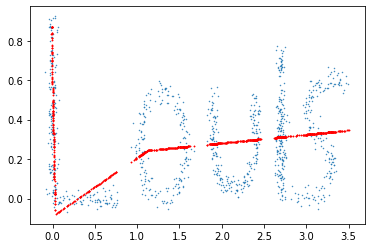

In [23]:
new_X = gen_louis(int(1e3))
recon_X, mu, logvar = model(new_X)

visualise(new_X, recon_X)

Well this needs some tweaking, I've only worked on this for an hour or so, I will come back soon and see what I can do.